# Przewidywanie, czy będą wysoko energetyczne zagrożenia sejsmiczne w kopalniach węgla

Celem projektu jest zbudowanie i porównanie kilku modeli przewidywań zagrożeń sejsmicznych w kopalniach węgla na podstawie zbioru danych: https://archive.ics.uci.edu/ml/datasets/seismic-bumps

Warto też sprawdzić, czy dane są wystarczające do przeprowadzenia nauczania.

Projekt zawiera:
- proces przetwarzania danych
- proces modelowania (znajdowania optymalnych parametrów)
- porównanie kilku modeli
- wizualizację wyników
- podsumowanie pracy

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import History
from keras import backend

### Proces przetwarzania danych
Dane musimy:
- przyczyscic z nulli jesli wystepuja
- uzupelnic header w danych, ktory jest zle skomponowany w pliku .csv
- usunac niepotrzebne kolumny, ktore nie maja wplywu na nauczanie

Opis danych (źródło - zbiór danych):
```
1. seismic: result of shift seismic hazard assessment in the mine working obtained by the seismic method (a - lack of hazard, b - low hazard, c - high hazard, d - danger state);
2. seismoacoustic: result of shift seismic hazard assessment in the mine working obtained by the seismoacoustic method;
3. shift: information about type of a shift (W - coal-getting, N -preparation shift);
4. genergy: seismic energy recorded within previous shift by the most active geophone (GMax) out of geophones monitoring the longwall;
5. gpuls: a number of pulses recorded within previous shift by GMax;
6. gdenergy: a deviation of energy recorded within previous shift by GMax from average energy recorded during eight previous shifts;
7. gdpuls: a deviation of a number of pulses recorded within previous shift by GMax from average number of pulses recorded during eight previous shifts;
8. ghazard: result of shift seismic hazard assessment in the mine working obtained by the seismoacoustic method based on registration coming form GMax only;
9. nbumps: the number of seismic bumps recorded within previous shift;
10. nbumps2: the number of seismic bumps (in energy range [10^2,10^3)) registered within previous shift;
11. nbumps3: the number of seismic bumps (in energy range [10^3,10^4)) registered within previous shift;
12. nbumps4: the number of seismic bumps (in energy range [10^4,10^5)) registered within previous shift;
13. nbumps5: the number of seismic bumps (in energy range [10^5,10^6)) registered within the last shift;
14. nbumps6: the number of seismic bumps (in energy range [10^6,10^7)) registered within previous shift;
15. nbumps7: the number of seismic bumps (in energy range [10^7,10^8)) registered within previous shift;
16. nbumps89: the number of seismic bumps (in energy range [10^8,10^10)) registered within previous shift;
17. energy: total energy of seismic bumps registered within previous shift;
18. maxenergy: the maximum energy of the seismic bumps registered within previous shift;
19. class: the decision attribute - "1" means that high energy seismic bump occurred in the next shift ("hazardous state"), "0" means that no high energy seismic bumps occurred in the next shift ("non-hazardous state").
```

In [9]:
FILENAME = "seismic-bumps.csv"
START_ROW = 154

def getHeaders():
    headers = []
    with open(FILENAME, 'r') as f:
        first_lines = f.read().splitlines()[:START_ROW]
        
        for line in first_lines:
            if line.startswith('@attribute'):
                headers.append(line.split(' ')[1])
    return headers

data = pd.read_csv(FILENAME, names=getHeaders(), skiprows=START_ROW)
data.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,a,a,N,15180,48,-72,-72,a,0,0,0,0,0,0,0,0,0,0,0
1,a,a,N,14720,33,-70,-79,a,1,0,1,0,0,0,0,0,2000,2000,0
2,a,a,N,8050,30,-81,-78,a,0,0,0,0,0,0,0,0,0,0,0
3,a,a,N,28820,171,-23,40,a,1,0,1,0,0,0,0,0,3000,3000,0
4,a,a,N,12640,57,-63,-52,a,0,0,0,0,0,0,0,0,0,0,0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2584 entries, 0 to 2583
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   seismic         2584 non-null   object
 1   seismoacoustic  2584 non-null   object
 2   shift           2584 non-null   object
 3   genergy         2584 non-null   int64 
 4   gpuls           2584 non-null   int64 
 5   gdenergy        2584 non-null   int64 
 6   gdpuls          2584 non-null   int64 
 7   ghazard         2584 non-null   object
 8   nbumps          2584 non-null   int64 
 9   nbumps2         2584 non-null   int64 
 10  nbumps3         2584 non-null   int64 
 11  nbumps4         2584 non-null   int64 
 12  nbumps5         2584 non-null   int64 
 13  nbumps6         2584 non-null   int64 
 14  nbumps7         2584 non-null   int64 
 15  nbumps89        2584 non-null   int64 
 16  energy          2584 non-null   int64 
 17  maxenergy       2584 non-null   int64 
 18  class   

Jak widac, mamy wartosci tekstowe, ktore trzeba bedzie przerobic na liczbowe. Sprawdzmy jakie sa wartosci:

In [11]:
print(data["seismic"].value_counts())
print(data["seismoacoustic"].value_counts())
print(data["shift"].value_counts())
print(data["ghazard"].value_counts())

a    1682
b     902
Name: seismic, dtype: int64
a    1580
b     956
c      48
Name: seismoacoustic, dtype: int64
W    1663
N     921
Name: shift, dtype: int64
a    2342
b     212
c      30
Name: ghazard, dtype: int64


Przerobmy te dane teraz i je wyswietlmy:

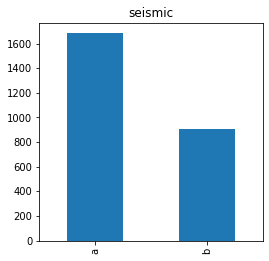

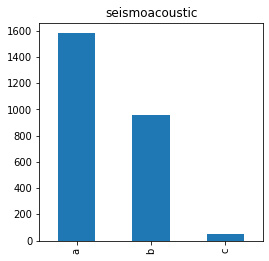

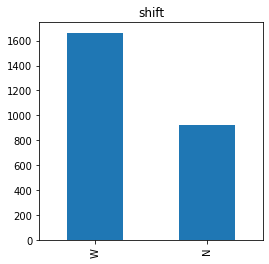

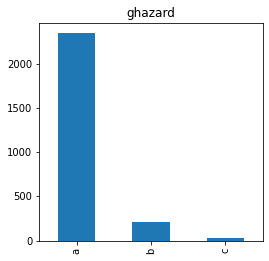

In [12]:
data["seismic"].value_counts().plot(kind="bar", figsize=(4,4))
plt.title("seismic")
plt.show()
data["seismic"] = data["seismic"].replace({"a": 0, "b": 1})

data["seismoacoustic"].value_counts().plot(kind="bar", figsize=(4,4))
plt.title("seismoacoustic")
plt.show()
data["seismoacoustic"] = data["seismoacoustic"].replace({"a": 0, "b": 1, "c": 2})

data["shift"].value_counts().plot(kind="bar", figsize=(4,4))
plt.title("shift")
plt.show()
data["shift"] = data["shift"].replace({"W": 0, "N": 1})

data["ghazard"].value_counts().plot(kind="bar", figsize=(4,4))
plt.title("ghazard")
plt.show()
data["ghazard"] = data["ghazard"].replace({"a": 0, "b": 1, "c": 2})

Upewnijmy sie, ze wszystkie dane sa liczbowe:

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2584 entries, 0 to 2583
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   seismic         2584 non-null   int64
 1   seismoacoustic  2584 non-null   int64
 2   shift           2584 non-null   int64
 3   genergy         2584 non-null   int64
 4   gpuls           2584 non-null   int64
 5   gdenergy        2584 non-null   int64
 6   gdpuls          2584 non-null   int64
 7   ghazard         2584 non-null   int64
 8   nbumps          2584 non-null   int64
 9   nbumps2         2584 non-null   int64
 10  nbumps3         2584 non-null   int64
 11  nbumps4         2584 non-null   int64
 12  nbumps5         2584 non-null   int64
 13  nbumps6         2584 non-null   int64
 14  nbumps7         2584 non-null   int64
 15  nbumps89        2584 non-null   int64
 16  energy          2584 non-null   int64
 17  maxenergy       2584 non-null   int64
 18  class           2584 non-nul

Wyswietlmy teraz dane wszystkich kategorii:

In [14]:
for key in data:
    print(data[key].value_counts(), "" , sep="\n")

0    1682
1     902
Name: seismic, dtype: int64

0    1580
1     956
2      48
Name: seismoacoustic, dtype: int64

0    1663
1     921
Name: shift, dtype: int64

7400     5
11230    4
19420    4
15300    4
6790     4
        ..
18210    1
32930    1
39690    1
60340    1
12750    1
Name: genergy, Length: 2212, dtype: int64

19      12
213      9
17       9
46       9
402      8
        ..
1375     1
941      1
770      1
1419     1
372      1
Name: gpuls, Length: 1128, dtype: int64

-14     29
-32     28
-7      26
-38     25
-10     25
        ..
 626     1
 135     1
 190     1
 279     1
 213     1
Name: gdenergy, Length: 334, dtype: int64

 0      35
-32     35
-14     30
 2      29
 6      29
        ..
 113     1
 163     1
 245     1
 235     1
 150     1
Name: gdpuls, Length: 292, dtype: int64

0    2342
1     212
2      30
Name: ghazard, dtype: int64

0    1464
1     598
2     245
3     127
4      69
5      38
6      28
8       7
7       5
9       3
Name: nbumps, dtype: int64


Mozemy przyuwazyc, ze "nbumps6", "nbumps7" i "nbumps89" maja tylko 0 - te dane nic nie wnosza. Usuwamy te kolumny

In [8]:
data = data.drop(["nbumps6", "nbumps7", "nbumps89"], axis=1)
data.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,energy,maxenergy,class
0,0,0,1,15180,48,-72,-72,0,0,0,0,0,0,0,0,0
1,0,0,1,14720,33,-70,-79,0,1,0,1,0,0,2000,2000,0
2,0,0,1,8050,30,-81,-78,0,0,0,0,0,0,0,0,0
3,0,0,1,28820,171,-23,40,0,1,0,1,0,0,3000,3000,0
4,0,0,1,12640,57,-63,-52,0,0,0,0,0,0,0,0,0


Sprawdzmy ilosc klas:

In [9]:
print(data["class"].value_counts())

0    2414
1     170
Name: class, dtype: int64


Mamy niezbalansowany dataset. Z tego powodu robie downsampling klasy "0", by wyrownac mniej wiecej do "1".

In [10]:
#data = data.drop(data[data['class'] == 0].sample(frac=.93).index)

class_1_over = data[data['class'] == 0].sample(len(data[data['class'] == 1]))
data = pd.concat([class_1_over, data[data['class'] == 1]], axis=0)
print(data["class"].value_counts())

0    170
1    170
Name: class, dtype: int64


Teraz posiadamy w miare wyrownany dataset. Niestety mamy dosc malo danych i jest duza szansa ze accuracy bedzie niskie. Sprawdzmy teraz nulle.

In [11]:
data.isnull().sum()

seismic           0
seismoacoustic    0
shift             0
genergy           0
gpuls             0
gdenergy          0
gdpuls            0
ghazard           0
nbumps            0
nbumps2           0
nbumps3           0
nbumps4           0
nbumps5           0
energy            0
maxenergy         0
class             0
dtype: int64

In [12]:
#data = data.drop(["seismic", "seismoacoustic", "nbumps4", "nbumps5"], axis=1)
#data.head()

Posiadamy 0 wartosci nullowych, wiec ich nie usuwamy. Wyswietlmy teraz wykresy:

C:\Users\Holo\AppData\Local\Temp\ipykernel_30668\1593497570.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


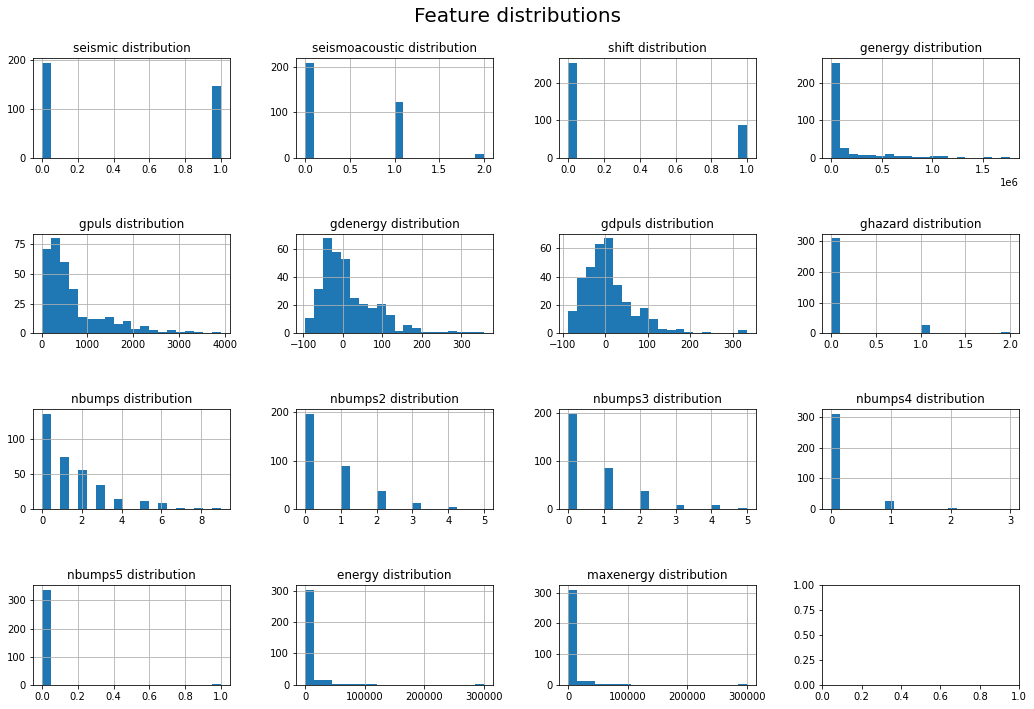

In [13]:
fig, axs = plt.subplots(4, 4, figsize=(15,10))

i = 0
j = 0

for feature in list(data.columns[:-1]):
  data[feature].hist(bins=20,ax=axs[i,j])
  axs[i,j].set_title(feature + " distribution")
  j=j+1
  if j == 4:
    i=i+1
    j=0  

fig.tight_layout(pad=3.0)
fig.suptitle("Feature distributions", fontsize=20, verticalalignment='bottom')
fig.show()

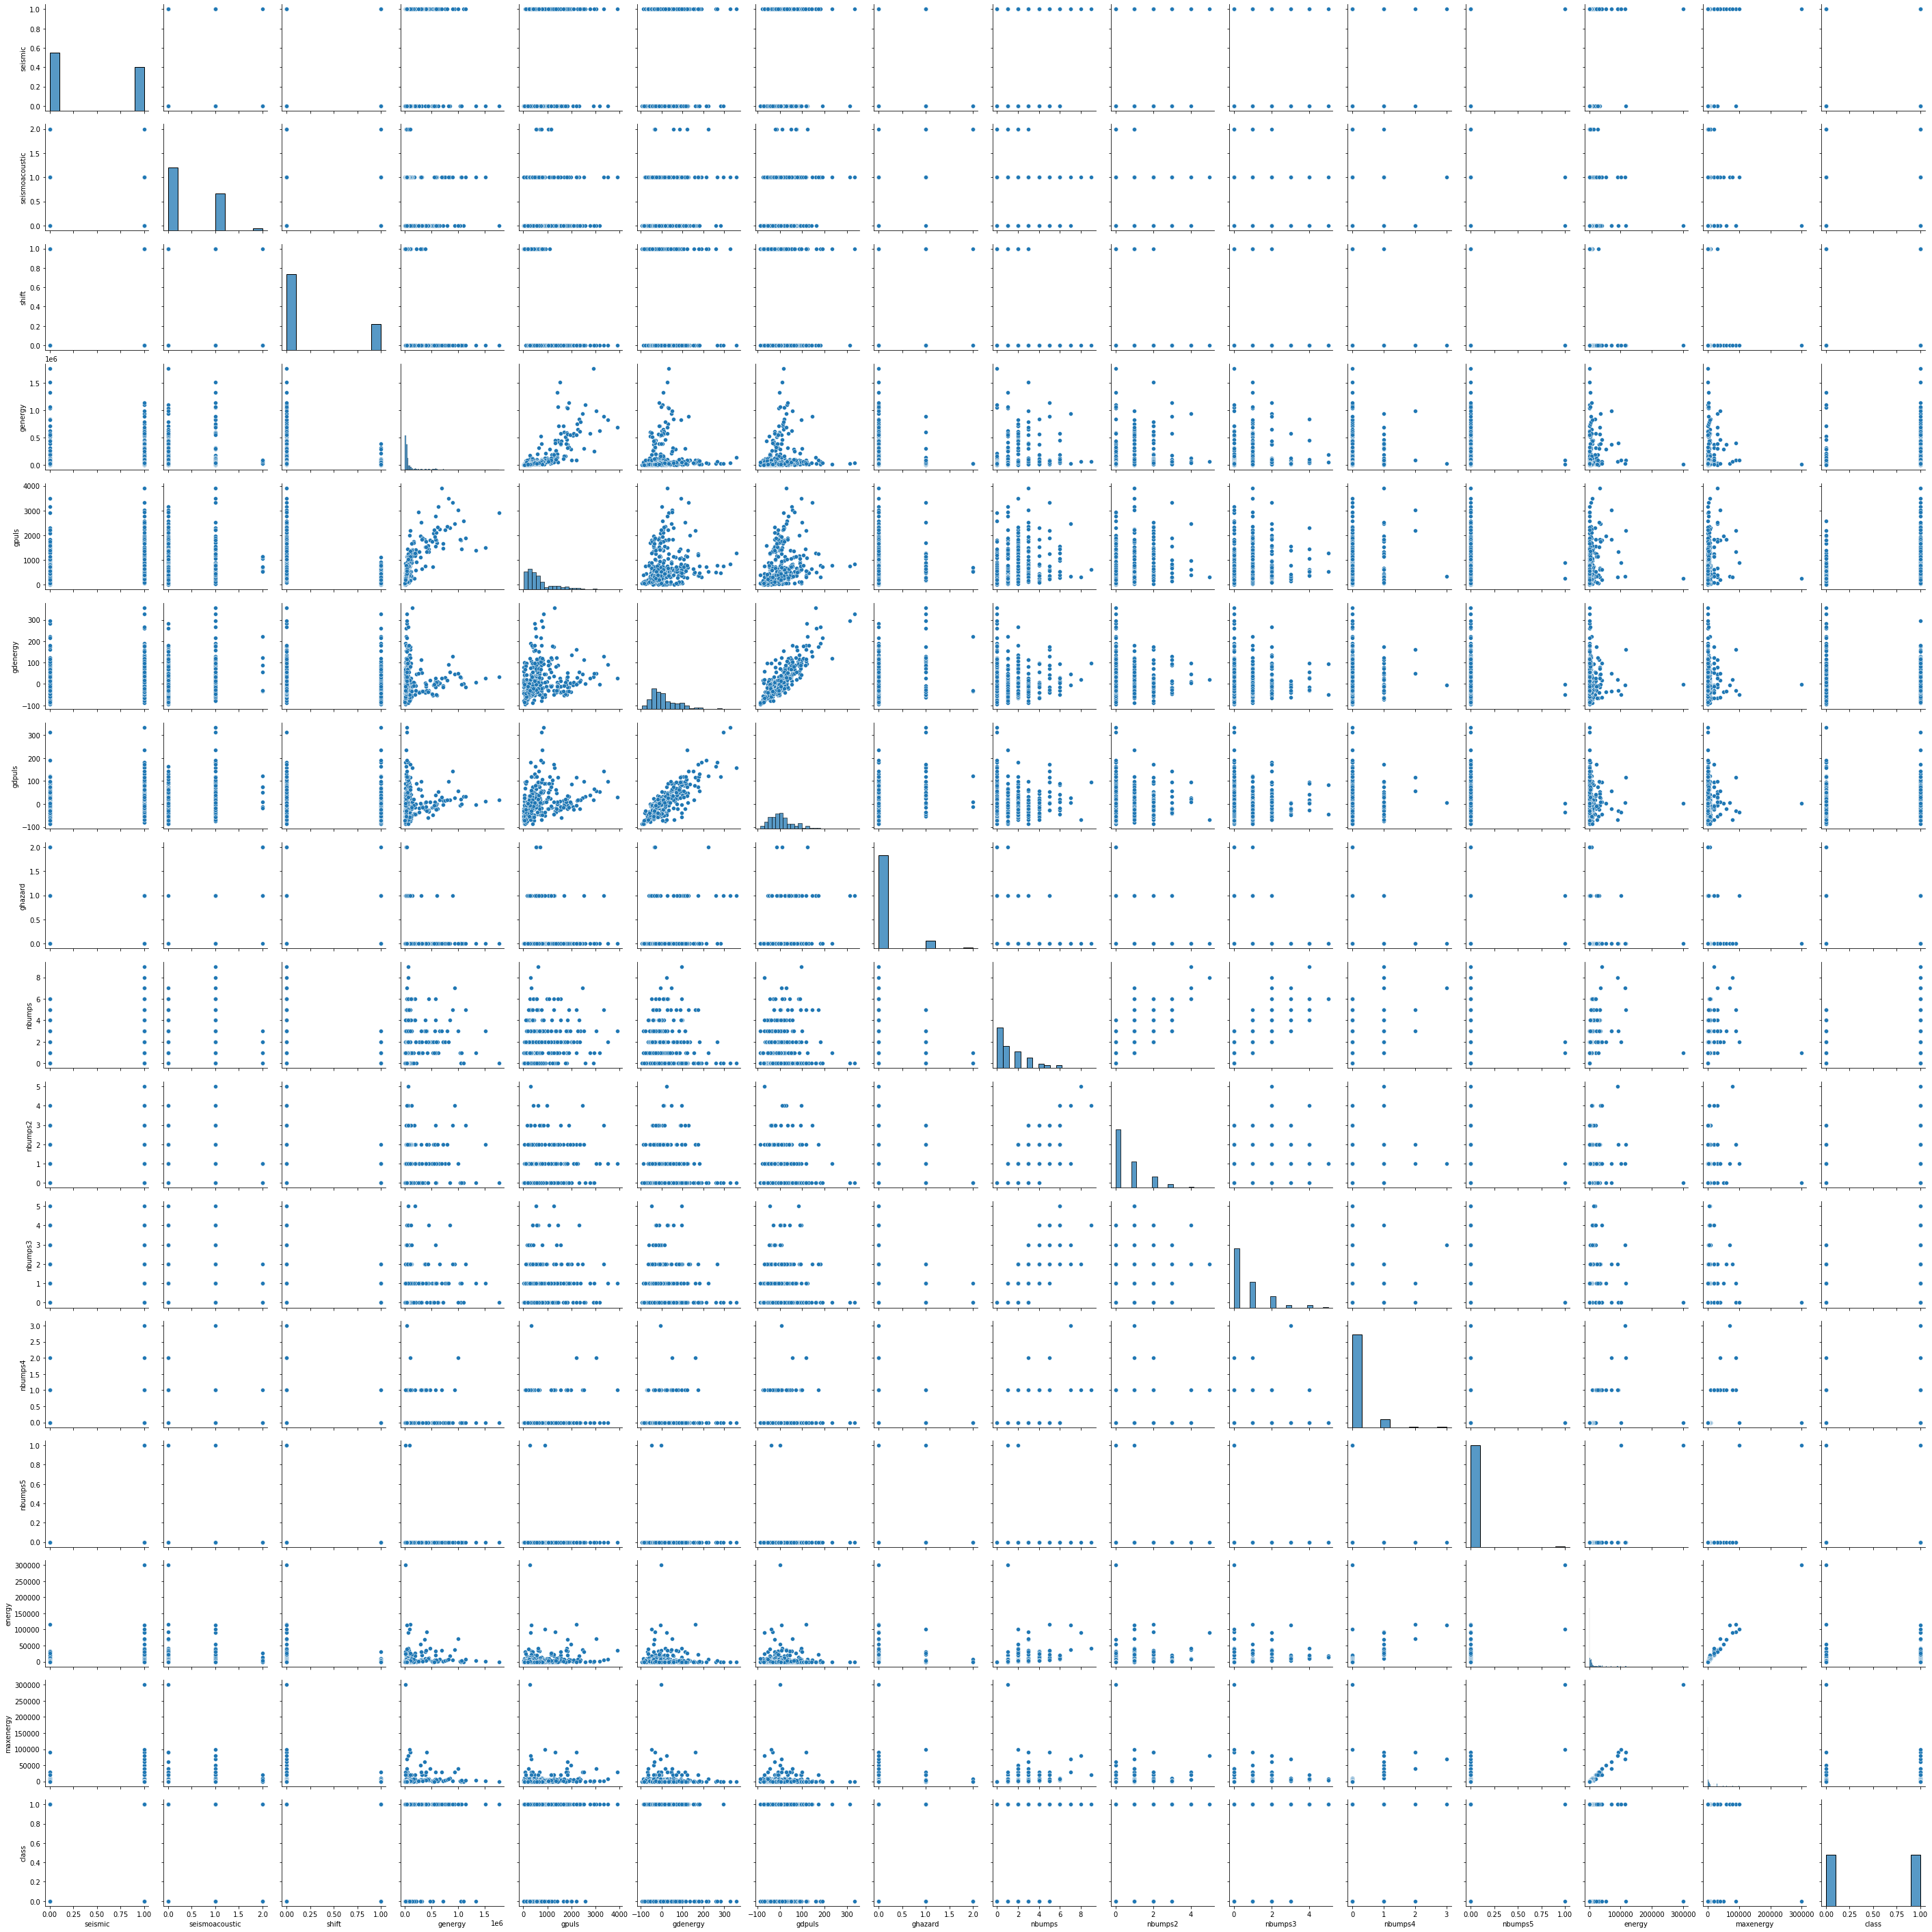

In [14]:
sns.pairplot(data)
plt.show()

In [15]:
corr = data.loc[:, data.columns != "class"].corr()
corr

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,energy,maxenergy
seismic,1.000000,0.024298,-0.272414,0.090325,0.301366,0.147947,0.182474,0.088437,0.161062,0.093940,0.105153,0.213217,0.088671,0.192939,0.183560
seismoacoustic,0.024298,1.000000,-0.008323,0.014251,0.029164,0.226763,0.256692,0.473071,0.046061,0.033955,0.037339,0.036880,0.014065,0.004147,-0.006669
shift,-0.272414,-0.008323,1.000000,-0.233942,-0.393290,-0.013120,-0.011769,-0.028089,-0.346446,-0.293638,-0.277395,-0.129227,-0.044760,-0.154078,-0.130040
genergy,0.090325,0.014251,-0.233942,1.000000,0.767493,0.001331,0.044513,-0.051015,0.228658,0.210076,0.153006,0.129433,-0.025348,0.088273,0.066526
gpuls,0.301366,0.029164,-0.393290,0.767493,1.000000,0.180795,0.270346,0.064298,0.271702,0.212922,0.186486,0.240327,-0.013247,0.161495,0.132848
gdenergy,0.147947,0.226763,-0.013120,0.001331,0.180795,1.000000,0.839861,0.265275,-0.049328,-0.042805,-0.045802,0.031162,-0.043752,-0.016931,-0.026775
gdpuls,0.182474,0.256692,-0.011769,0.044513,0.270346,0.839861,1.000000,0.296256,-0.022415,-0.041752,-0.012246,0.054222,-0.033797,-0.003265,-0.017298
ghazard,0.088437,0.473071,-0.028089,-0.051015,0.064298,0.265275,0.296256,1.000000,-0.078012,-0.036197,-0.101947,-0.007869,0.095524,-0.008771,0.002474
nbumps,0.161062,0.046061,-0.346446,0.228658,0.271702,-0.049328,-0.022415,-0.078012,1.000000,0.804749,0.812037,0.399355,0.002524,0.368297,0.271353
nbumps2,0.093940,0.033955,-0.293638,0.210076,0.212922,-0.042805,-0.041752,-0.036197,0.804749,1.000000,0.365240,0.205319,-0.013041,0.194059,0.144642


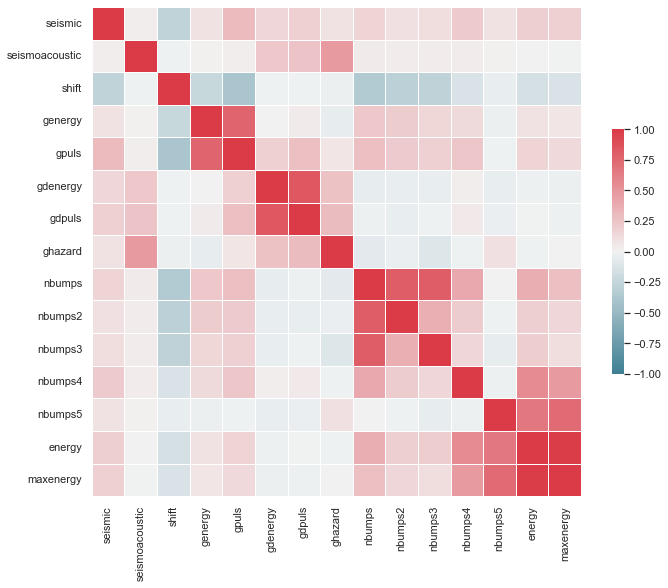

In [16]:
sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.show()

# Szukanie za pomoca SVC dobrego accuracy z danymi

Probowalem wyszukac odpowienich parametrow do SVC na bazie danych:
- nie usuwajac zadnych rekordow
- downsampling'ujac
- upsampling'ujac
- orginalnych danych wraz z 2000 syntentycznami danymi
- orginalnych danych wraz z 2000 syntentycznami danymi i downsamplingujac

Oto wyniki accuracy z SVC i wyniki modelu:

In [17]:
%matplotlib inline
from IPython.display import Image

### Normalne dane:

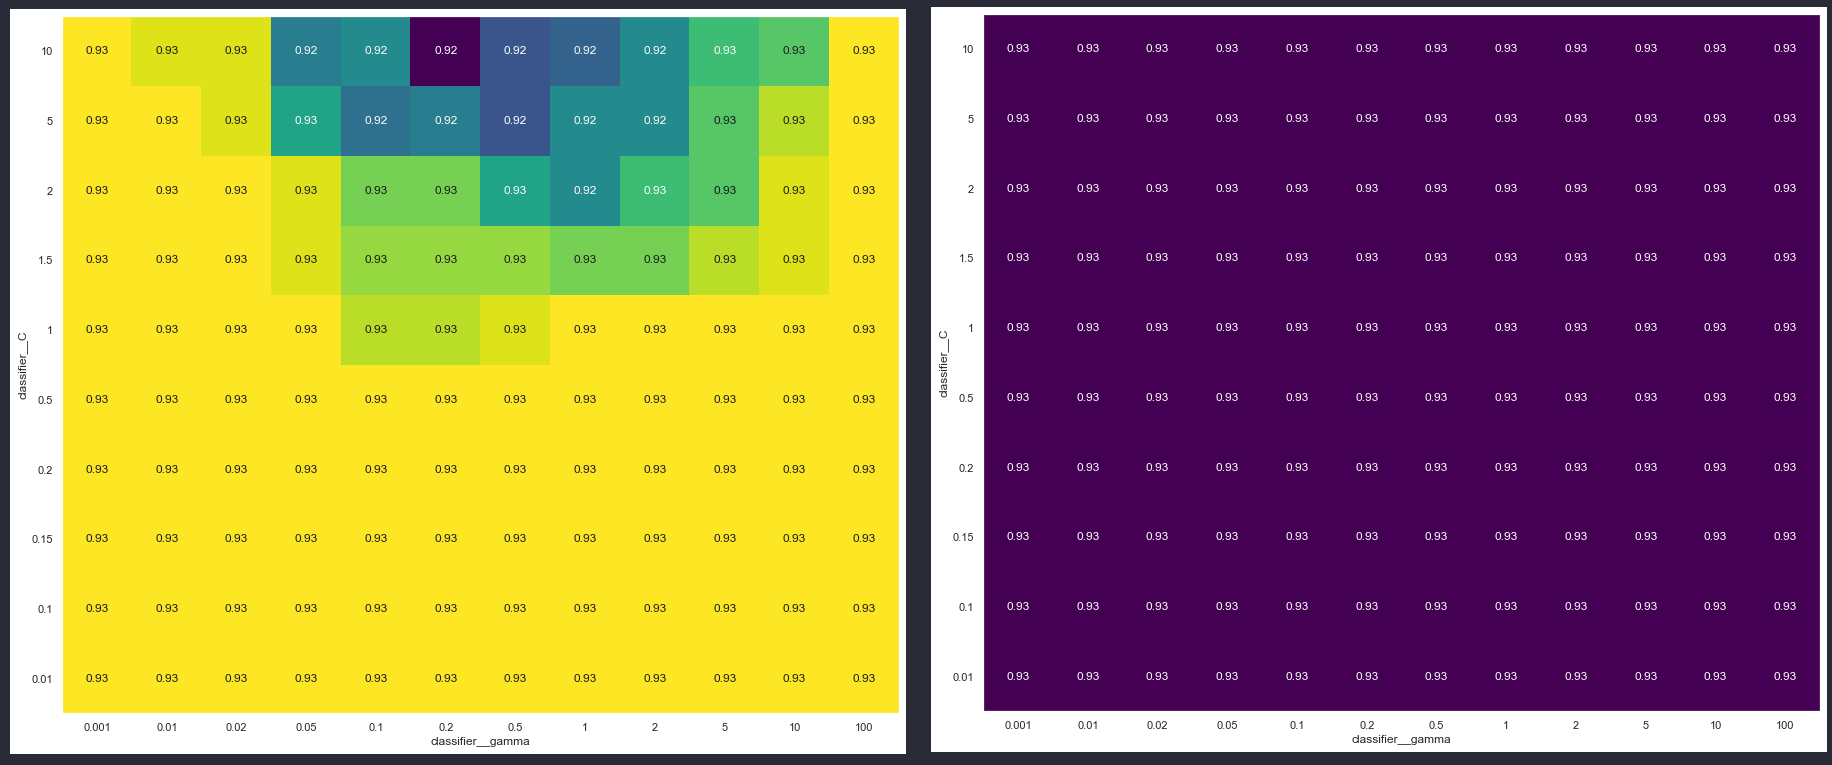

In [18]:
Image('files/normal.png')

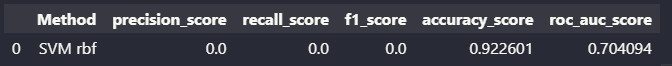

In [19]:
Image('files/normal_score.png')

### Syntetyczne dane

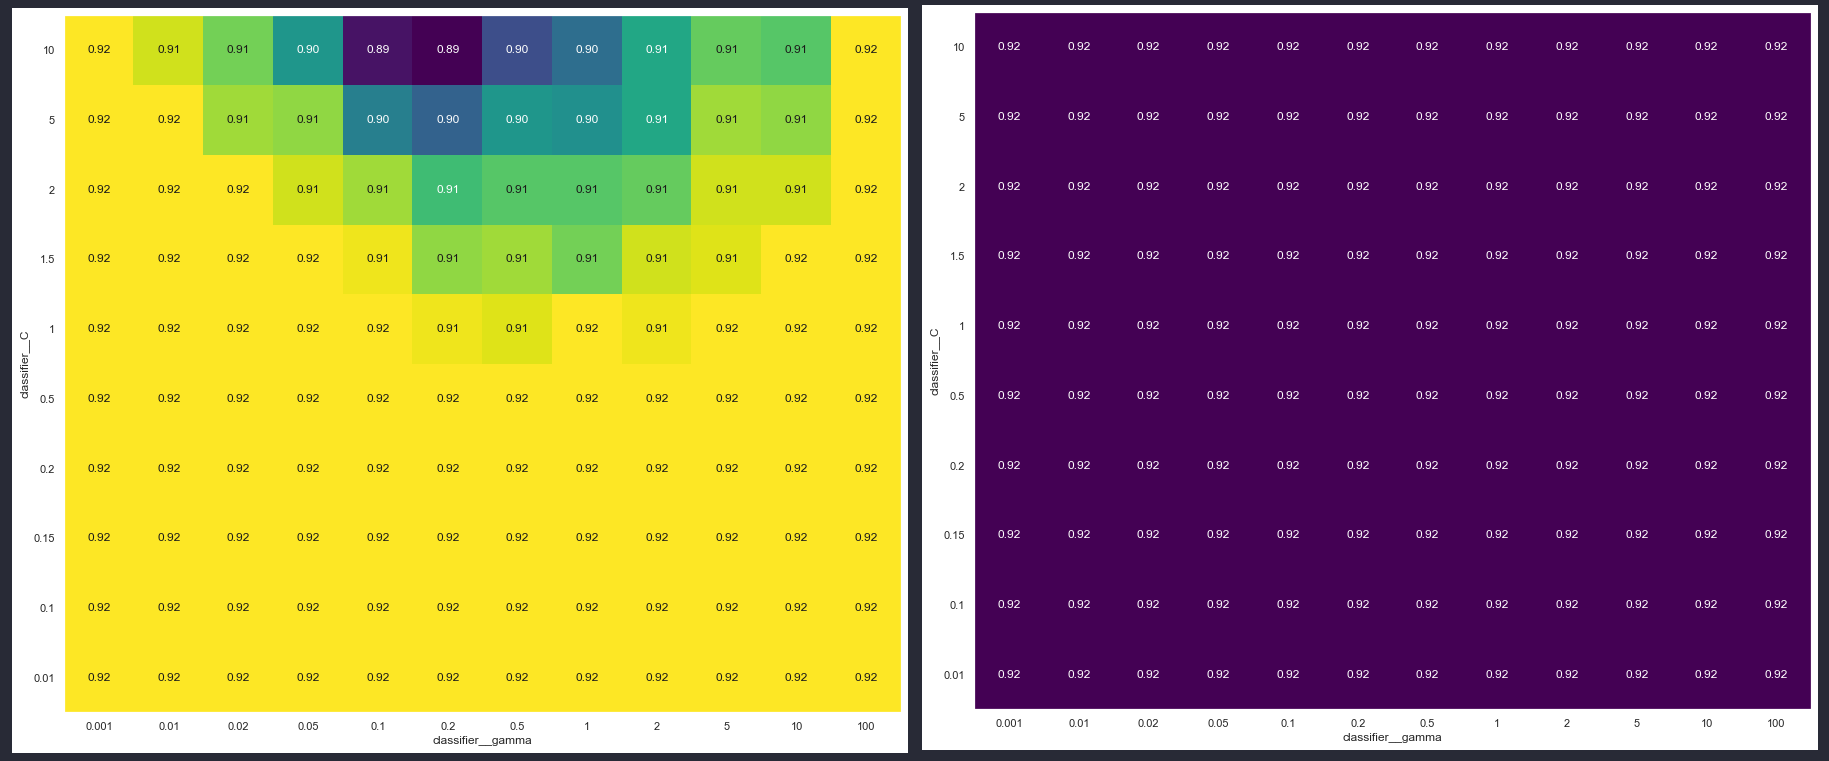

In [20]:
Image('files/synthetic.png')

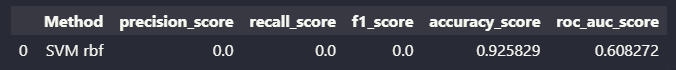

In [21]:
Image('files/synthetic_score.png')

### Syntetyczne dane z downsamplingiem

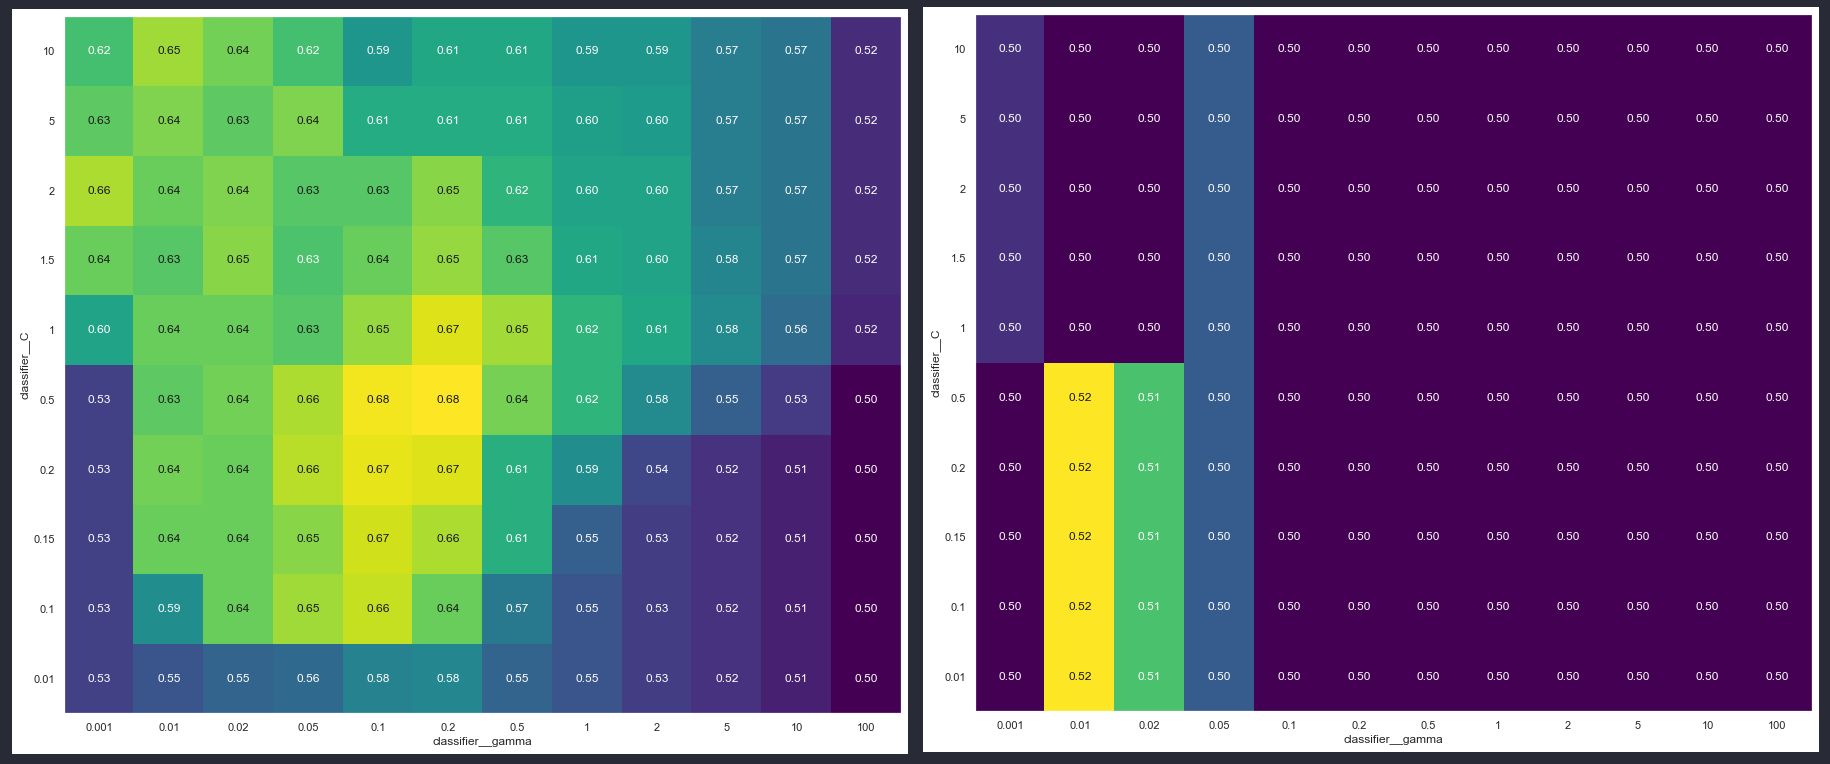

In [22]:
Image('files/synthetic_downsampling.png')

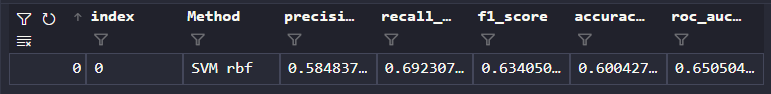

In [23]:
Image('files/synthetic_downscampling_score.png')

### Downsampling

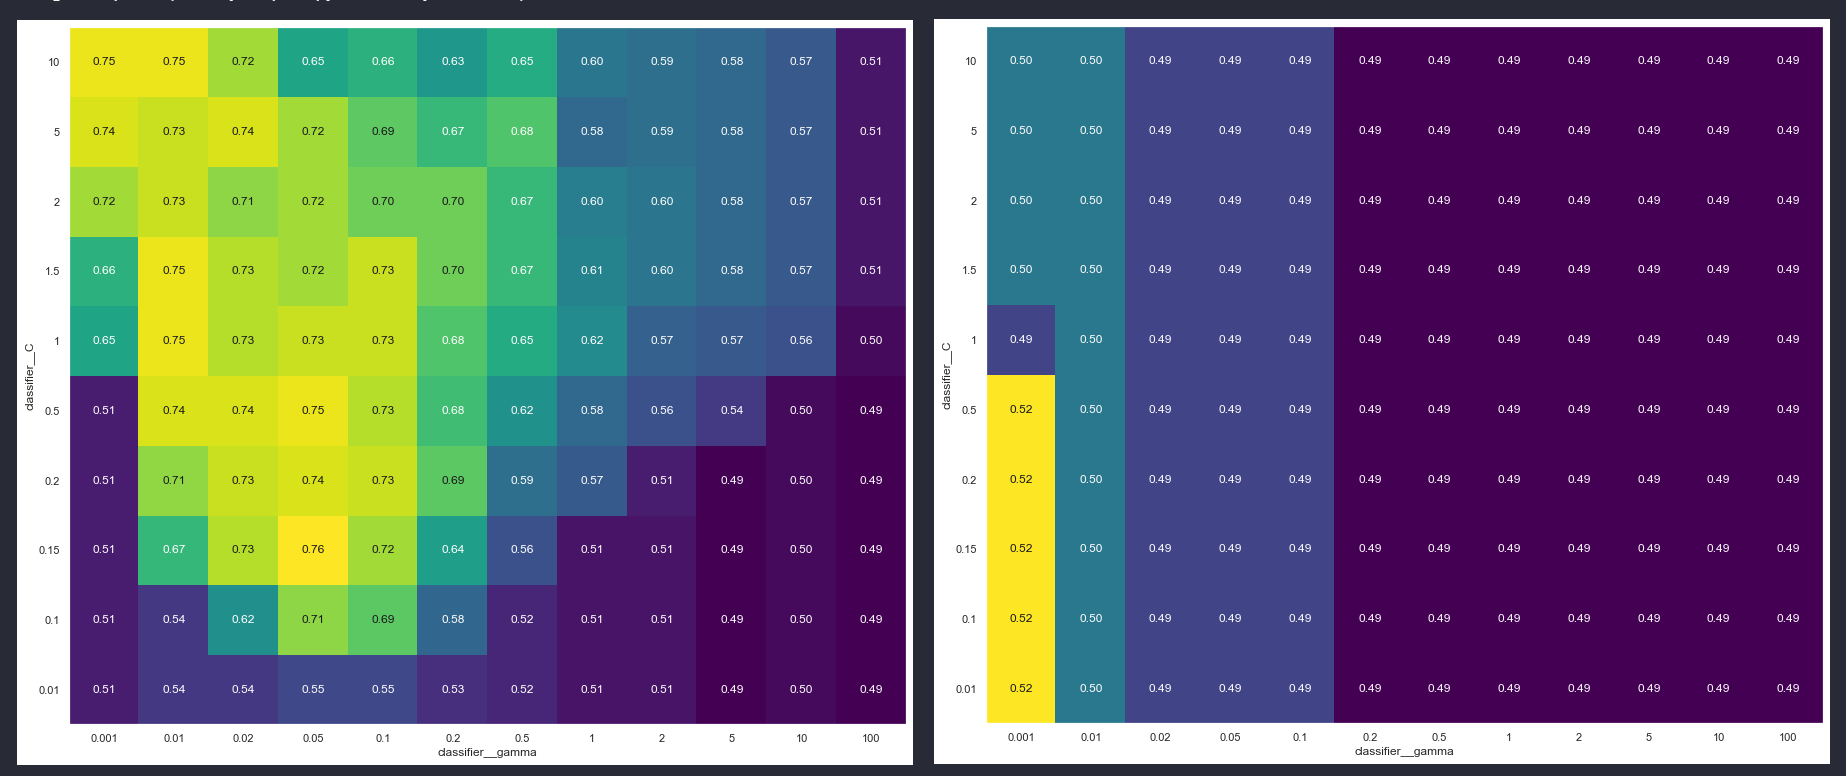

In [24]:
Image('files/undersampling.png')

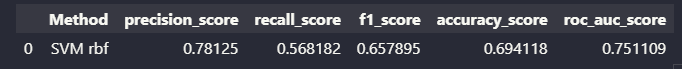

In [25]:
Image('files/undersampling_score.png')

### Upsampling

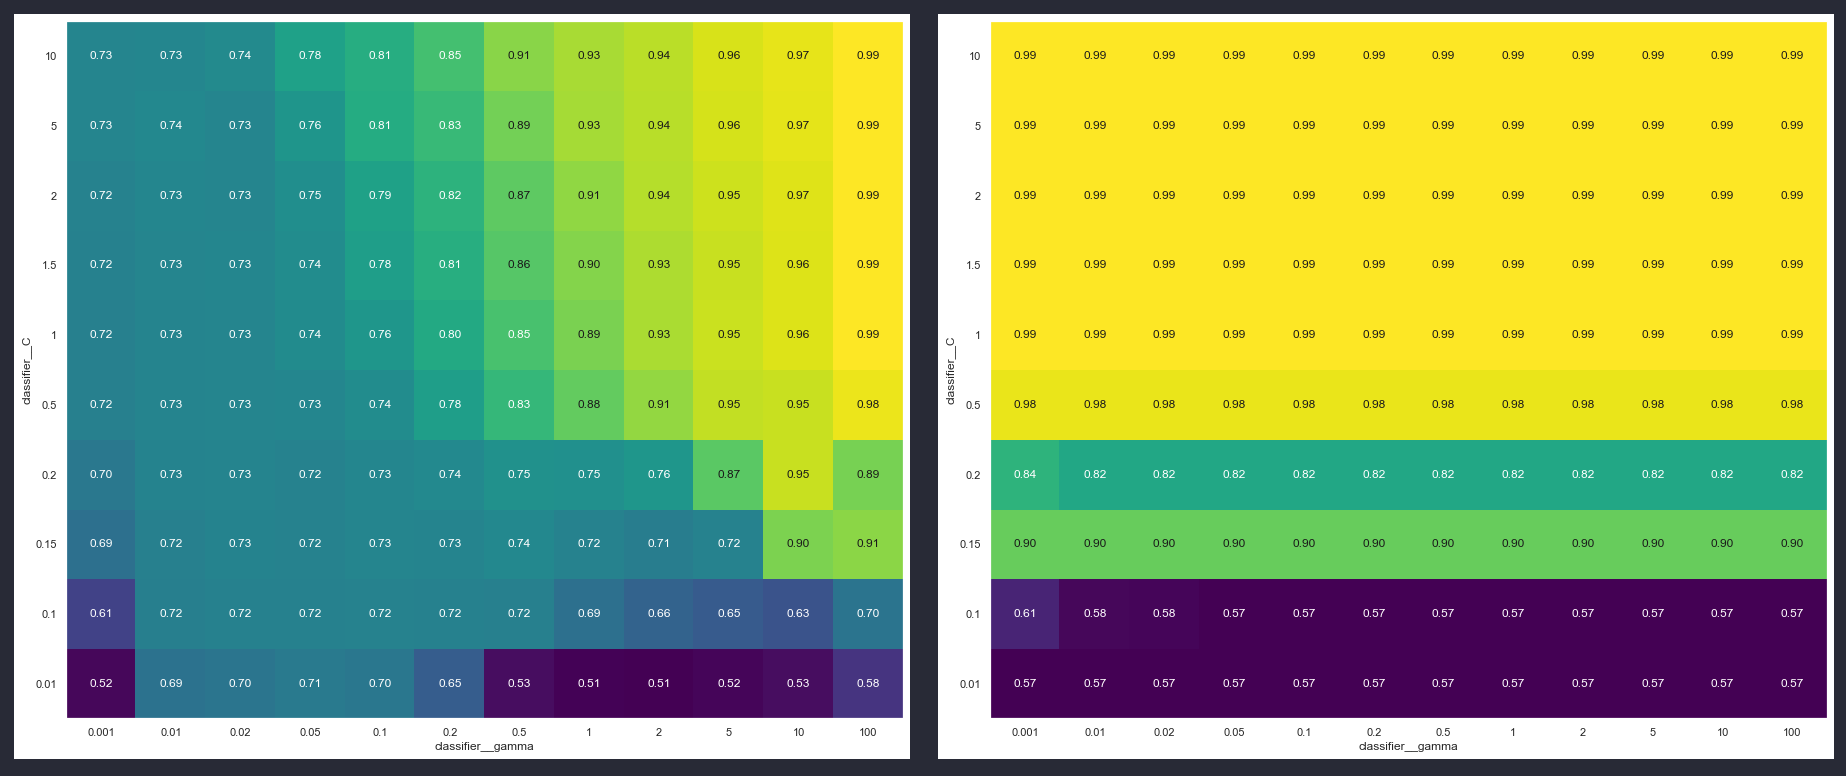

In [26]:
Image('files/upsampling.png')

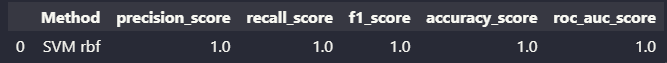

In [27]:
Image('files/upsampling_score.png')

Dlatego postanowilem zdownsamplowac dane, wiedzac, ze jest ich malo. Jest bardzo duza szansa ze nasza siec neuronowa bedzie miala male accuracy przez to. Ponizej znajduje sie kod na syntetyczne dane, ktore uzywalem:

```python
from ctgan import CTGANSynthesizer
ctgan = CTGANSynthesizer(batch_size=50, epochs=5, verbose=False)
ctgan.fit(data, data.keys())
samples = ctgan.sample(2000)
data = pd.concat([data, samples])
print(data)
```

# Modelowanie danych

Podzielmy dataset na train i test tak, by klas bylo po rowno

In [28]:
from sklearn.model_selection import train_test_split

X = data.loc[:, data.columns != "class"]
y = data["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=0, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(136, 15) (136,)
(204, 15) (204,)


In [29]:
X_train.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,energy,maxenergy
717,1,0,0,167100,1690,-7,-6,0,1,0,1,0,0,7000,7000
696,1,1,0,83490,898,-49,-37,1,2,1,0,0,1,100300,100000
2217,1,2,0,84510,1049,87,51,1,1,1,0,0,0,200,200
1661,1,1,0,59210,705,73,23,0,2,0,2,0,0,4000,2000
649,0,1,0,44770,770,-22,2,0,1,0,1,0,0,1000,1000


In [30]:
y_train.head()

717     1
696     1
2217    0
1661    0
649     1
Name: class, dtype: int64

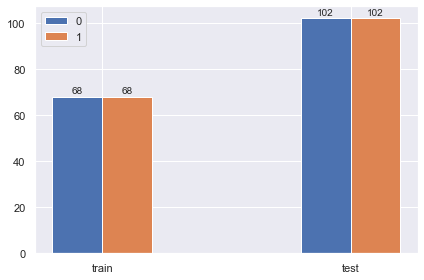

In [31]:
labels = ["train", "test"]
x_plot = np.arange(len(labels))
width = 0.2

data_plot1 = [(y_train == 0).sum(), (y_test == 0).sum()]
data_plot2 = [(y_train == 1).sum(), (y_test == 1).sum()]
fig, ax = plt.subplots()
rects1 = ax.bar(x_plot - width/2, data_plot1, width, label='0')
rects2 = ax.bar(x_plot + width/2, data_plot2, width, label='1')
ax.set_xticks(x_plot, labels)
ax.legend()
ax.bar_label(rects1, padding=1)
ax.bar_label(rects2, padding=1)
fig.tight_layout()
plt.show()

Zdefiniujmy seeda i kfolda. Przy storzmy funkcje do tworzenia heatmap.

In [32]:
seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

In [33]:
pipeline1 = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(probability=True))])

param_grid_1 = {
            'preprocessing': [StandardScaler(), None],
            'classifier__gamma': [0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 100],
            'classifier__C': [0.01, 0.1, 0.15, 0.2, 0.5, 1, 1.5, 2, 5, 10]
}

grid_1 = GridSearchCV(pipeline1, param_grid_1, cv=kfold, return_train_score=True)

grid_1.fit(X_train, y_train)
print(grid_1.best_params_)

{'classifier__C': 1.5, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}


In [34]:
pipeline_2 = Pipeline([('preprocessing', StandardScaler()), ('classifier', LogisticRegression(n_jobs=-1))])

param_grid_2 = {
            'preprocessing': [StandardScaler(), None],
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_2 = GridSearchCV(pipeline_2, param_grid_2, cv=kfold, return_train_score=True) 
grid_2.fit(X_train, y_train)
grid_2.best_params_

{'classifier__C': 0.01, 'preprocessing': StandardScaler()}

In [35]:
pipeline_3 = Pipeline([('preprocessing', StandardScaler()), ('classifier', LinearSVC())])

param_grid_3 = {
            'preprocessing': [StandardScaler(), None],
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_3 = GridSearchCV(pipeline_3, param_grid_3, cv=kfold, return_train_score=True)

grid_3.fit(X_train, y_train)
grid_3.best_params_

c:\Users\Holo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Holo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Holo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Holo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Holo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'classifier__C': 0.001, 'preprocessing': StandardScaler()}

In [36]:
pipeline_4 = Pipeline([('preprocessing', StandardScaler()), ('classifier', KNeighborsClassifier(n_jobs=-1))])

param_grid_4 = {
            'preprocessing': [StandardScaler(), None],
            'classifier__p': [1, 10, 100, 1000, 10000]
}

grid_4 = GridSearchCV(pipeline_4, param_grid_4, cv=kfold, return_train_score=True)

grid_4.fit(X_train, y_train)
grid_4.best_params_

{'classifier__p': 10, 'preprocessing': StandardScaler()}

In [37]:
pipeline_5 = Pipeline([('preprocessing', StandardScaler()), ('classifier', DecisionTreeClassifier())])

param_grid_5 = {
            'preprocessing': [StandardScaler(), None],
            'classifier__max_depth': [1, 5, 10, 20],
            'classifier__max_leaf_nodes': [None, 5, 10, 20, 50, 100],
}

grid_5 = GridSearchCV(pipeline_5, param_grid_5, cv=kfold, return_train_score=True)

grid_5.fit(X_train, y_train)
grid_5.best_params_

{'classifier__max_depth': 10,
 'classifier__max_leaf_nodes': 20,
 'preprocessing': StandardScaler()}

In [38]:
pipeline_6 = Pipeline([('preprocessing', StandardScaler()), ('classifier', RandomForestClassifier(n_jobs=-1))])

param_grid_6 = {
            'preprocessing': [StandardScaler(), None],
            'classifier__n_estimators' : [1, 3, 5, 10, 50],
            'classifier__max_leaf_nodes' : [2, 4, 8, 16, 32, 64],
}

grid_6 = GridSearchCV(pipeline_6, param_grid_6, cv=kfold, return_train_score=True)

grid_6.fit(X_train, y_train)
grid_6.best_params_

{'classifier__max_leaf_nodes': 4,
 'classifier__n_estimators': 50,
 'preprocessing': StandardScaler()}

In [39]:
pipeline_7 = Pipeline([('preprocessing', StandardScaler()), ('classifier', BaggingClassifier())])

param_grid_7 = {
            'preprocessing': [StandardScaler(), None],
            'classifier__max_samples' : [0.05, 0.1, 0.2, 0.5, 0.7, 1]
}

grid_7 = GridSearchCV(pipeline_7, param_grid_7, cv=kfold, return_train_score=True)

grid_7.fit(X_train, y_train)
grid_7.best_params_

{'classifier__max_samples': 0.05, 'preprocessing': StandardScaler()}

In [40]:
pipeline_8 = Pipeline([('preprocessing', StandardScaler()), ('classifier', ExtraTreesClassifier(n_jobs=-1))])

param_grid_8 = {
            'preprocessing': [StandardScaler(), None],
            'classifier__n_estimators' : [5, 10, 50, 100],
            'classifier__max_leaf_nodes' : [2, 4, 8, 16, 32, 64],
}

grid_8 = GridSearchCV(pipeline_8, param_grid_8, cv=kfold, return_train_score=True)

grid_8.fit(X_train, y_train)
grid_8.best_params_

{'classifier__max_leaf_nodes': 4,
 'classifier__n_estimators': 10,
 'preprocessing': StandardScaler()}

In [41]:
pipeline_9 = Pipeline([('preprocessing', StandardScaler()), ('classifier', AdaBoostClassifier())])

param_grid_9 = {
            'preprocessing': [StandardScaler(), None],
            'classifier__n_estimators' : [5, 10, 50, 100, 500, 600, 700],
            'classifier__learning_rate' : [0.001, 0.01, 0.1, 0.5, 0.7, 1],
}

grid_9 = GridSearchCV(pipeline_9, param_grid_9, cv=kfold, return_train_score=True)

grid_9.fit(X_train, y_train)
grid_9.best_params_

{'classifier__learning_rate': 0.5,
 'classifier__n_estimators': 10,
 'preprocessing': StandardScaler()}

In [42]:
pipeline_10 = Pipeline([('preprocessing', StandardScaler()), ('classifier', GradientBoostingClassifier())])

param_grid_10 = {
            'preprocessing': [StandardScaler(), None],
            'classifier__n_estimators' : [5, 10, 50, 100, 500],
            'classifier__learning_rate' : [0.001, 0.01, 0.1, 0.5, 0.7, 1],
}

grid_10 = GridSearchCV(pipeline_10, param_grid_10, cv=kfold, return_train_score=True)

grid_10.fit(X_train, y_train)
grid_10.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__n_estimators': 10,
 'preprocessing': StandardScaler()}

### Ktore featury sa wazne?

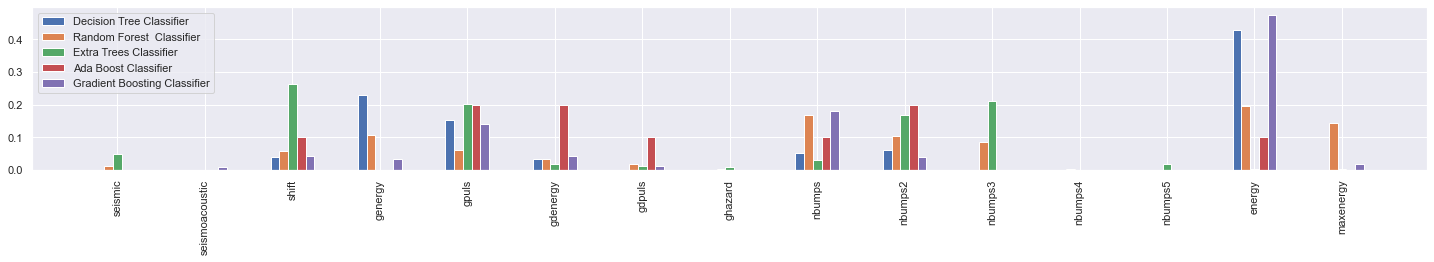

In [43]:
fig, ax = plt.subplots(figsize=(25,3))
objects = list(X_train.columns)
x = np.arange(len(objects))

ax.bar(x-0.2, grid_5.best_estimator_.named_steps["classifier"].feature_importances_, width=0.1, align='center', label="Decision Tree Classifier")
ax.bar(x-0.1, grid_6.best_estimator_.named_steps["classifier"].feature_importances_, width=0.1, align='center', label="Random Forest  Classifier")
ax.bar(x, grid_8.best_estimator_.named_steps["classifier"].feature_importances_, width=0.1, align='center', label="Extra Trees Classifier")
ax.bar(x+0.1, grid_9.best_estimator_.named_steps["classifier"].feature_importances_, width=0.1, align='center', label="Ada Boost Classifier")
ax.bar(x+0.2, grid_10.best_estimator_.named_steps["classifier"].feature_importances_, width=0.1, align='center', label="Gradient Boosting Classifier")

plt.xticks(x, objects, rotation=90)
plt.legend()
plt.show()

### Porownanie modeli

In [44]:
from sklearn import metrics

models = []
models.append(('SVM rbf', grid_1.best_estimator_))
models.append(('Logistic regression', grid_2.best_estimator_))
models.append(('LinearSVC', grid_3.best_estimator_))
models.append(('KNeighborsClassifier', grid_4.best_estimator_))
models.append(('DecisionTreeClassifier', grid_5.best_estimator_))
models.append(('RandomForestClassifier', grid_6.best_estimator_))
models.append(('BaggingClassifier', grid_7.best_estimator_))
models.append(('ExtraTreesClassifier', grid_8.best_estimator_))
models.append(('AdaBoostClassifier', grid_9.best_estimator_))
models.append(('GradientBoostingClassifier', grid_10.best_estimator_))

precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
roc_auc_score = []
for name, model in models:
    precision_score.append(metrics.precision_score(y_test , model.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test , model.predict(X_test)))
    f1_score.append( metrics.f1_score(y_test , model.predict(X_test)))
    accuracy_score.append(metrics.accuracy_score(y_test , model.predict(X_test)))
    if (name == 'LinearSVC'):
        roc_auc_score.append(metrics.roc_auc_score(y_test , model.decision_function(X_test)))        
    else:    
        roc_auc_score.append(metrics.roc_auc_score(y_test , model.predict_proba(X_test)[:,1]))

In [45]:
d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score,
     'roc_auc_score' : roc_auc_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['SVM rbf', 'Logistic regression', 'LinearSVC', 'KNeighborsClassifier', 'DecisionTreeClassifier', 'RandomForestClassifier', 'BaggingClassifier', 'ExtraTreesClassifier', 'AdaBoostClassifier','GradientBoostingClassifier'])
df

,Method,precision_score,recall_score,f1_score,accuracy_score,roc_auc_score
0,SVM rbf,0.746988,0.607843,0.670270,0.700980,0.733660
1,Logistic regression,0.720930,0.607843,0.659574,0.686275,0.735967
2,LinearSVC,0.743902,0.598039,0.663043,0.696078,0.735582
3,KNeighborsClassifier,0.692308,0.617647,0.652850,0.671569,0.698866
4,DecisionTreeClassifier,0.680000,0.666667,0.673267,0.676471,0.628268
5,RandomForestClassifier,0.685393,0.598039,0.638743,0.661765,0.743128
6,BaggingClassifier,0.753086,0.598039,0.666667,0.700980,0.717272
7,ExtraTreesClassifier,0.636364,0.617647,0.626866,0.632353,0.727605
8,AdaBoostClassifier,0.707317,0.568627,0.630435,0.666667,0.707805
9,GradientBoostingClassifier,0.670455,0.578431,0.621053,0.647059,0.740532


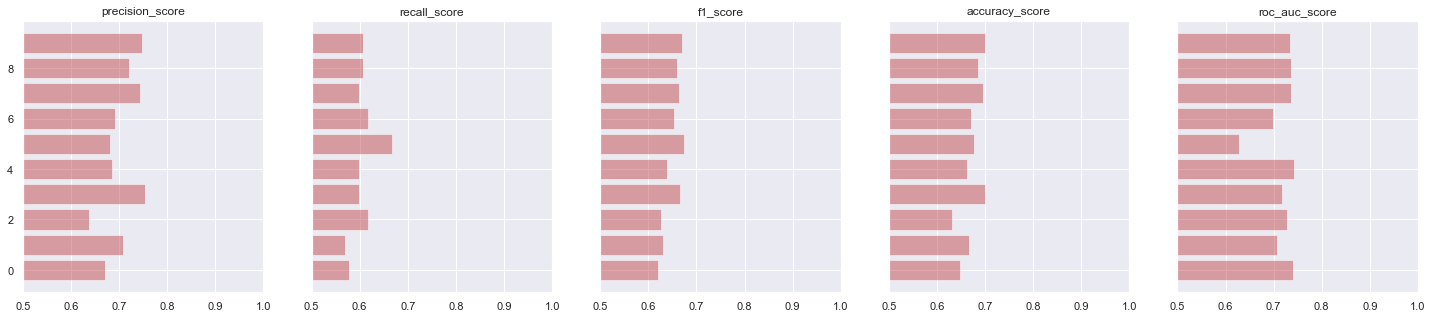

In [46]:
fig, axs = plt.subplots(1, 5, figsize=(25,5), sharey=True)

objects = [name for (name, model) in models]
objects.reverse()
y_pos = np.arange(len(objects))

j = 0

for name in d:
  performance = d[name]
  performance.reverse()
  colors = ['r' if p < 1 else 'b' for p in performance]
  axs[j].barh(y_pos, performance, align='center', alpha=0.5, color=colors)
  axs[j].set_title(name)
  j+=1

for ax in axs:
  ax.set_xlim([0.5, 1])

C:\Users\Holo\AppData\Local\Temp\ipykernel_30668\1856903830.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


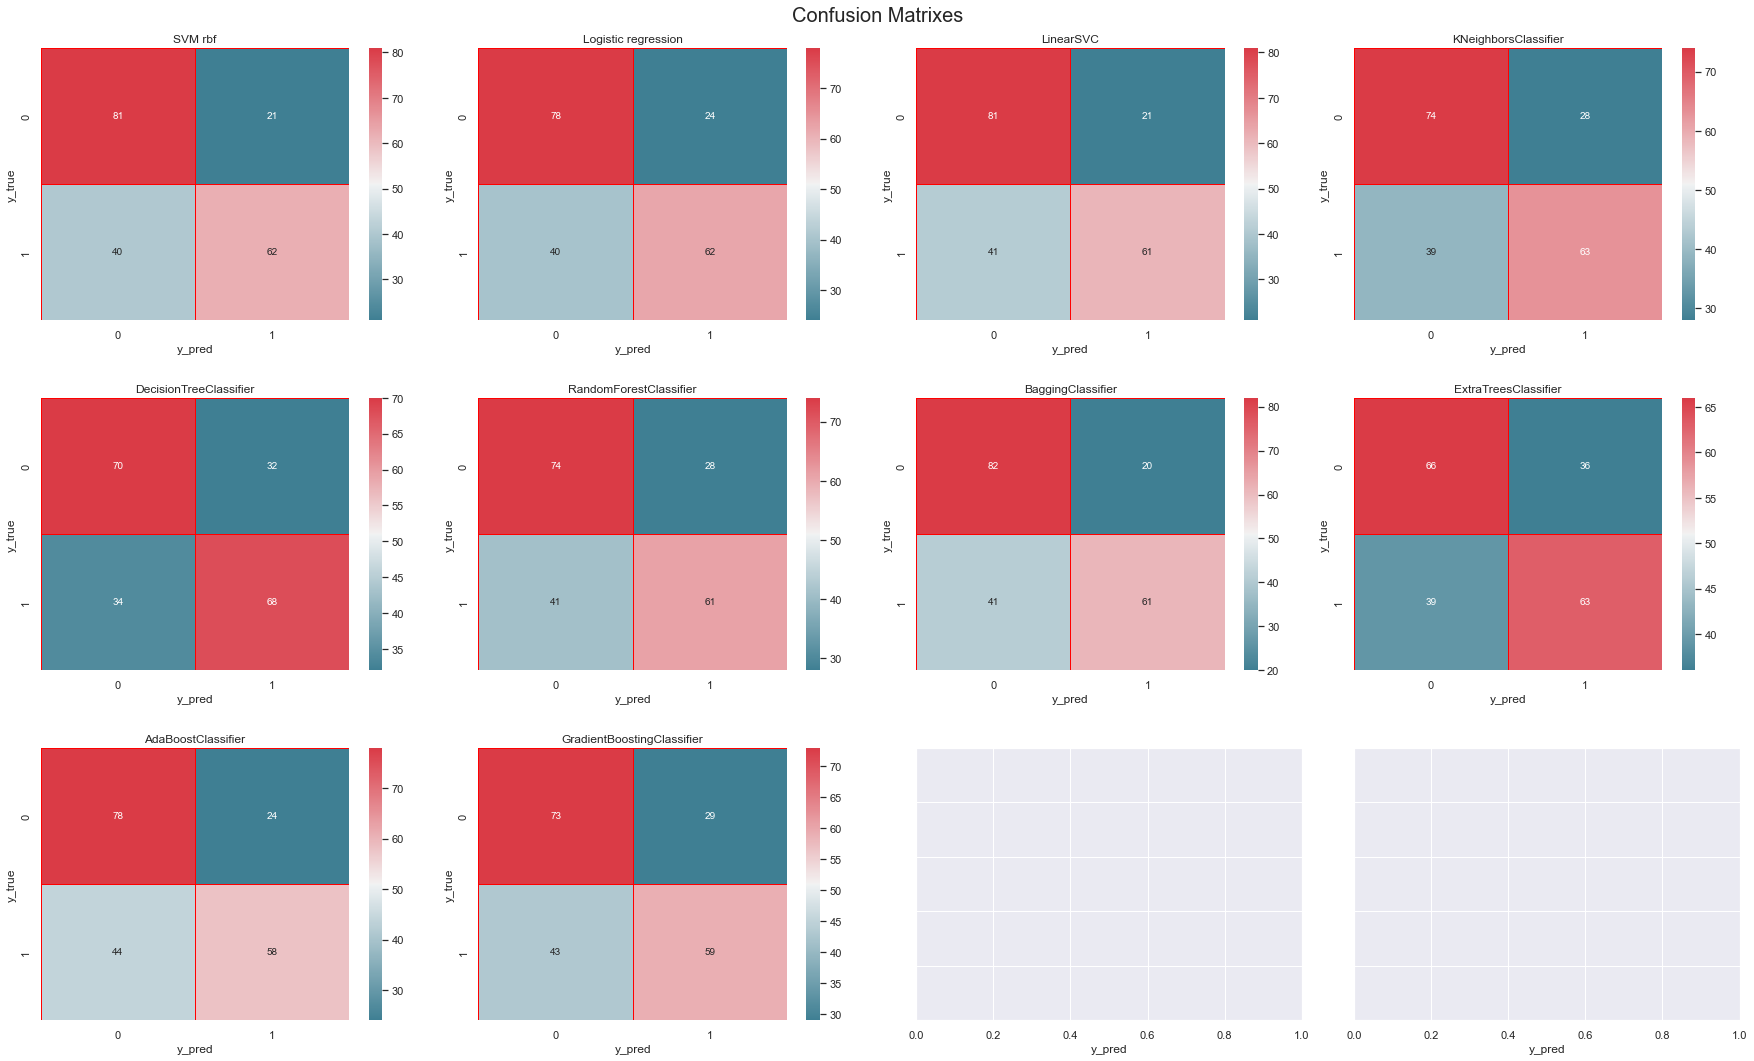

In [47]:
from sklearn.metrics import confusion_matrix

fig, axs = plt.subplots(3, 4, figsize=(25,15))

i = 0
j = 0

for name, model in models:
  cm = confusion_matrix(y_test, model.predict(X_test))
  sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",cmap=cmap,fmt=".0f",ax=axs[i,j])
  axs[i,j].set_title(name)
  j=j+1
  if j == 4:
    i=i+1
    j=0  

for ax in axs.flat:
    ax.set(xlabel='y_pred', ylabel='y_true')
    ax.label_outer()

fig.tight_layout(pad=3.0)
fig.suptitle("Confusion Matrixes", fontsize=20, verticalalignment='bottom')
fig.show()

# Sieci neuronowe

Stworzmy model MLPRegressor i MLPClassifier

In [48]:
from sklearn.neural_network import MLPRegressor, MLPClassifier
pipeline_13 = Pipeline([('preprocessing', StandardScaler()), ('classifier', MLPClassifier())])

param_grid_13 = {
            'preprocessing': [StandardScaler(), None],
            'classifier__hidden_layer_sizes': [(20,10)],
            'classifier__learning_rate_init': [0.001, 0.01, 0.1],
            'classifier__max_iter': [100, 500, 1000],
            'classifier__batch_size': [8, 16,32],
}

grid_13 = GridSearchCV(pipeline_13, param_grid_13, cv=kfold, return_train_score=True)

grid_13.fit(X_train, y_train)
print(grid_13.best_params_)

models.append(('MLP Classifier', grid_13.best_estimator_))
precision_score.append(metrics.precision_score(y_test , models[-1][1].predict(X_test)))
recall_score.append(metrics.recall_score(y_test , models[-1][1].predict(X_test)))
f1_score.append( metrics.f1_score(y_test , models[-1][1].predict(X_test)))
accuracy_score.append(metrics.accuracy_score(y_test , models[-1][1].predict(X_test)))
roc_auc_score.append(metrics.roc_auc_score(y_test , models[-1][1].predict_proba(X_test)[:,1]))

c:\Users\Holo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Holo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Holo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Holo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization

{'classifier__batch_size': 32, 'classifier__hidden_layer_sizes': (20, 10), 'classifier__learning_rate_init': 0.001, 'classifier__max_iter': 100, 'preprocessing': StandardScaler()}


c:\Users\Holo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [49]:
pipeline_14 = Pipeline([('preprocessing', StandardScaler()), ('classifier', MLPRegressor())])

param_grid_14 = {
            'preprocessing': [StandardScaler(), None],
            'classifier__hidden_layer_sizes': [(20,10)],
            'classifier__learning_rate_init': [0.0001, 0.001, 0.01, 0.1, 1],
            'classifier__max_iter': [5000, 50000, 500000],
            'classifier__batch_size':[10, 20, 30, 40],
}

grid_14 = GridSearchCV(pipeline_14, param_grid_14, cv=kfold, return_train_score=True)

grid_14.fit(X_train, y_train)
grid_14.best_params_

{'classifier__batch_size': 10,
 'classifier__hidden_layer_sizes': (20, 10),
 'classifier__learning_rate_init': 0.0001,
 'classifier__max_iter': 5000,
 'preprocessing': StandardScaler()}

Zbudujmy model

In [50]:
backend.clear_session()

history = History()

model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dense(100,activation="relu"))
model.add(Dense(50,activation="relu"))
model.add(Dense(1,activation="relu"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              16000     
                                                                 
 dense_1 (Dense)             (None, 100)               100100    
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 121,201
Trainable params: 121,201
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(loss="binary_crossentropy",optimizer="Adam", metrics=["accuracy"])

In [52]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

history = model.fit(X_train_scaled, y_train, validation_data= (X_test_scaled, y_test), batch_size=32, epochs=200)

Epoch 1/200
5/5 [==============================] - 1s 63ms/step - loss: 1.5620 - accuracy: 0.5662 - val_loss: 1.5072 - val_accuracy: 0.5539
Epoch 2/200
5/5 [==============================] - 0s 10ms/step - loss: 1.3881 - accuracy: 0.6838 - val_loss: 1.0444 - val_accuracy: 0.6618
Epoch 3/200
5/5 [==============================] - 0s 13ms/step - loss: 0.7034 - accuracy: 0.7794 - val_loss: 1.0674 - val_accuracy: 0.6814
Epoch 4/200
5/5 [==============================] - 0s 10ms/step - loss: 0.5594 - accuracy: 0.7353 - val_loss: 1.0179 - val_accuracy: 0.7059
Epoch 5/200
5/5 [==============================] - 0s 9ms/step - loss: 0.5213 - accuracy: 0.7721 - val_loss: 0.9487 - val_accuracy: 0.6814
Epoch 6/200
5/5 [==============================] - 0s 11ms/step - loss: 0.4916 - accuracy: 0.7721 - val_loss: 1.2852 - val_accuracy: 0.7010
Epoch 7/200
5/5 [==============================] - 0s 13ms/step - loss: 0.4629 - accuracy: 0.8162 - val_loss: 1.3129 - val_accuracy: 0.6912
Epoch 8/200
5/5 [====

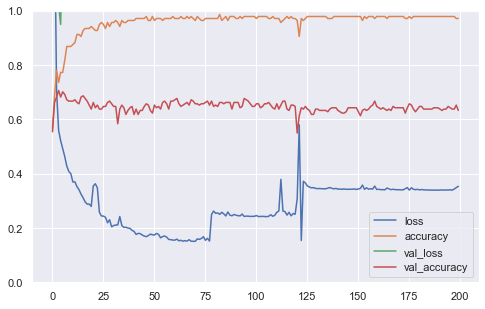

In [53]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [54]:
test_eval = model.evaluate(X_test_scaled, y_test)
test_eval

7/7 [==============================] - 0s 2ms/step - loss: 4.4412 - accuracy: 0.6324


[4.441229820251465, 0.6323529481887817]

In [55]:
metrics.accuracy_score(y_true=y_test, y_pred=(model.predict(X_test_scaled) > 0.5).astype("int32"))

7/7 [==============================] - 0s 1ms/step


0.6323529411764706

# Podsumowanie

Niestety, tak jak było spodziewane - mieliśmy za mało danych, na których mogliśmy porządnie wyćwiczyć modele i sieć neuronową. Też warto brać pod uwagę, że na trzęsienia sejsmiczne wpływa wiele czynników, których dane być może nie posiadały. Więc accuracy ~64% sieci neuronowej nie jest źle, jak na coś, co jest trudne do przewidzenia za pomoca geologicznych narzędzi. Brakuje wiecej danych z klasą "1" do precyzyjniejszych obliczeń.

# Niepotrzebny juz kod

```python
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img
```


```python
plt.rcParams["figure.figsize"] = (15, 15)
results = pd.DataFrame(grid_1.cv_results_)
scores = np.array(results.mean_test_score).reshape(10, 12, 2)
scores = scores[:,:,0]
heatmap(scores, xlabel='classifier__gamma', xticklabels=param_grid_1['classifier__gamma'], ylabel='classifier__C', yticklabels=param_grid_1['classifier__C'], cmap="viridis")
plt.show()
scores = np.array(results.mean_test_score).reshape(10, 12, 2)
scores = scores[:,:,1]
heatmap(scores, xlabel='classifier__gamma', xticklabels=param_grid_1['classifier__gamma'], ylabel='classifier__C', yticklabels=param_grid_1['classifier__C'], cmap="viridis")
plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
```